<a href="https://colab.research.google.com/github/AntonioLunardi/Challenge-Data-Science-Alura-2ed/blob/main/Challenge_DS_Alura_2_Ed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Inicialização do PySpark e importação do dataset

In [1]:
!pip install pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 15.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=6fcfb054186cb4c5b1e9ad1001377426d8727a3be454b5daaefe63c94546b3ca
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

In [4]:
!tar xf spark-3.3.1-bin-hadoop3.tgz

In [5]:
!pip install -q findspark

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [7]:
import findspark
findspark.init()

In [8]:
from pyspark.sql import SparkSession

In [9]:
spark = SparkSession.builder \
    .master('local[*]')\
    .appName('Challenge DS Alura 2 Ed')\
    .getOrCreate()

In [10]:
import json

dataset_bruto = spark.read.option('multiline', 'true').json('/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_bruto.json')

# 1.0 Engenharia de Dados

## 1.1 Visualização inicial

[Base de dados - InsightPlaces](https://caelum-online-public.s3.amazonaws.com/challenge-spark/semana-1.zip)

### Dicionário de Dados - Anuncio

| Colunas         | Descrição                                                      |
|-----------------|----------------------------------------------------------------|
| id              | Código de identificação do anúncio no sistema da InsightPlaces |
| tipo_unidade    | Tipo de imóvel (apartamento, casa e outros)                    |
| tipo_uso        | Tipo de uso do imóvel (residencial ou comercial)               |
| area_total      | Área total do imóvel (construção e terreno)                    |
| area_util       | Área construída do imóvel                                      |
| quartos         | Quantidade de quartos do imóvel                                |
| suites          | Quantidade de suítes do imóvel                                 |
| banheiros       | Quantidade de banheiros do imóvel                              |
| vaga            | Quantidade de vagas de garagem do imóvel                       |
| caracteristicas | Listagem de características do imóvel                          |
| andar           | Número do andar do imóvel                                      |
| endereco        | Informações sobre o endereço do imóvel                         |
| valores         | Informações sobre valores de venda e locação dos imóveis       |

In [11]:
dataset_bruto.printSchema() # Esquema de registro no arquivo JSON

root
 |-- anuncio: struct (nullable = true)
 |    |-- andar: long (nullable = true)
 |    |-- area_total: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- area_util: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- banheiros: array (nullable = true)
 |    |    |-- element: long (containsNull = true)
 |    |-- caracteristicas: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- endereco: struct (nullable = true)
 |    |    |-- bairro: string (nullable = true)
 |    |    |-- cep: string (nullable = true)
 |    |    |-- cidade: string (nullable = true)
 |    |    |-- estado: string (nullable = true)
 |    |    |-- latitude: double (nullable = true)
 |    |    |-- longitude: double (nullable = true)
 |    |    |-- pais: string (nullable = true)
 |    |    |-- rua: string (nullable = true)
 |    |    |-- zona: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-

In [12]:
quantidade_registros = dataset_bruto.count() # Quantidade de registros
quantidade_entidades = len(dataset_bruto.columns) # Entidades computadas (structs e arrays)

print('Quantidade de registros:', quantidade_registros)
print('\nQuantidade de entidades:', quantidade_entidades)

Quantidade de registros: 89083

Quantidade de entidades: 3


## 1.2 Seleção de features e transformação em colunas

In [13]:
# Transformando os dicionários JSON em colunas e selecionando features:
# A pedido do time de ciência de dados, não serão incluídas as colunas de endereço além de bairro e zona

dataset_anuncio_com_arrays = dataset_bruto\
  .select('anuncio.andar', 'anuncio.area_total', 'anuncio.area_util', 'anuncio.banheiros', 'anuncio.caracteristicas',\
          'anuncio.endereco.bairro', 'anuncio.endereco.zona', 'anuncio.id','anuncio.quartos', 'anuncio.suites',\
          'anuncio.tipo_anuncio', 'anuncio.tipo_unidade', 'anuncio.tipo_uso', 'anuncio.vaga',\
          'anuncio.valores.condominio', 'anuncio.valores.iptu', 'anuncio.valores.tipo', 'anuncio.valores.valor')

dataset_anuncio_com_arrays.show()

+-----+----------+---------+---------+--------------------+--------------+------------+--------------------+-------+------+------------+------------+-----------+----+----------+------+-------+-------+
|andar|area_total|area_util|banheiros|     caracteristicas|        bairro|        zona|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|condominio|  iptu|   tipo|  valor|
+-----+----------+---------+---------+--------------------+--------------+------------+--------------------+-------+------+------------+------------+-----------+----+----------+------+-------+-------+
|    0|        []|     [16]|      [0]|                  []|        Centro|Zona Central|47d553e0-79f2-4a4...|    [0]|   [0]|       Usado|      Outros|  Comercial| [1]|     [260]| [107]|[Venda]|[10000]|
|    0|        []|     [14]|      [0]|                  []|        Centro|Zona Central|b6ffbae1-17f6-487...|    [0]|    []|       Usado|      Outros|  Comercial| [0]|     [260]| [107]|[Venda]|[100

In [71]:
# Tranformando as colunas de arrays em strings para facilitar as análises e tratamentos

from pyspark.sql.functions import concat_ws

dataset_anuncio = dataset_anuncio_com_arrays # Trocando a váriável trabalhada

dataset_anuncio = dataset_anuncio.withColumn('area_total', concat_ws(',', 'area_total'))
dataset_anuncio = dataset_anuncio.withColumn('area_util', concat_ws(',', 'area_util'))
dataset_anuncio = dataset_anuncio.withColumn('banheiros', concat_ws(',', 'banheiros'))
dataset_anuncio = dataset_anuncio.withColumn('caracteristicas', concat_ws(',', 'caracteristicas'))
dataset_anuncio = dataset_anuncio.withColumn('quartos', concat_ws(',', 'quartos'))
dataset_anuncio = dataset_anuncio.withColumn('suites', concat_ws(',', 'suites'))
dataset_anuncio = dataset_anuncio.withColumn('vaga', concat_ws(',', 'vaga'))
dataset_anuncio = dataset_anuncio.withColumn('condominio', concat_ws(',', 'condominio'))
dataset_anuncio = dataset_anuncio.withColumn('iptu', concat_ws(',', 'iptu'))
dataset_anuncio = dataset_anuncio.withColumn('tipo', concat_ws(',', 'tipo'))
dataset_anuncio = dataset_anuncio.withColumn('valor', concat_ws(',', 'valor'))

dataset_anuncio.show() # Dataset após as modificações

+-----+----------+---------+---------+--------------------+--------------+------------+--------------------+-------+------+------------+------------+-----------+----+----------+----+-----+-----+
|andar|area_total|area_util|banheiros|     caracteristicas|        bairro|        zona|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|condominio|iptu| tipo|valor|
+-----+----------+---------+---------+--------------------+--------------+------------+--------------------+-------+------+------------+------------+-----------+----+----------+----+-----+-----+
|    0|          |       16|        0|                    |        Centro|Zona Central|47d553e0-79f2-4a4...|      0|     0|       Usado|      Outros|  Comercial|   1|       260| 107|Venda|10000|
|    0|          |       14|        0|                    |        Centro|Zona Central|b6ffbae1-17f6-487...|      0|      |       Usado|      Outros|  Comercial|   0|       260| 107|Venda|10000|
|    0|      1026|     10

## 1.3 Seleção dos valores de venda

In [72]:
# Verificando todas as categorias de registros de tipo (4 tipos).
# O anunciante pode registrar valores de venda ou de alguel na ordem que prefira.
# Assim, os valores registrados nos arrays 'valor', 'iptu' e 'condomínio' seguem a referência estabelecida por 'tipo'

dataset_anuncio_com_arrays\
    .groupby('tipo')\
    .count()\
    .show()

+----------------+-----+
|            tipo|count|
+----------------+-----+
|[Venda, Aluguel]| 1028|
|  [Venda, Venda]|   92|
|[Aluguel, Venda]|  811|
|         [Venda]|87152|
+----------------+-----+



In [73]:
# Visualizando como ficaram os 5 linhas de valores de um dos quatro tipos:

# 'Aluguel,Venda'
dataset_anuncio\
    .select(dataset_anuncio.valor.alias('Valor: Aluguel, Venda')\
            ,dataset_anuncio.iptu\
            ,dataset_anuncio.condominio)\
    .where(dataset_anuncio.tipo=='Aluguel,Venda')\
    .show(5)

# 'Venda'
dataset_anuncio\
    .select(dataset_anuncio.valor.alias('Valor: Venda')\
           ,dataset_anuncio.iptu, dataset_anuncio.condominio)\
    .where(dataset_anuncio.tipo=='Venda')\
    .show(5)

# 'Venda,Venda'
dataset_anuncio\
    .select(dataset_anuncio.valor.alias('Valor: Venda, Venda')\
            ,dataset_anuncio.iptu, dataset_anuncio.condominio)\
    .where(dataset_anuncio.tipo=='Venda,Venda')\
    .show(5)

# 'Venda,Aluguel'
dataset_anuncio\
    .select(dataset_anuncio.valor.alias('Valor: Venda, Aluguel')\
            ,dataset_anuncio.iptu, dataset_anuncio.condominio)\
    .where(dataset_anuncio.tipo=='Venda,Aluguel')\
    .show(5)

+---------------------+-------+----------+
|Valor: Aluguel, Venda|   iptu|condominio|
+---------------------+-------+----------+
|            500,15000|    117|       500|
|            250,38000|107,107|   295,295|
|            100,44000|126,126|   600,600|
|            550,60000|115,115|       0,0|
|            800,55000|    0,0|   200,200|
+---------------------+-------+----------+
only showing top 5 rows

+------------+----+----------+
|Valor: Venda|iptu|condominio|
+------------+----+----------+
|       10000| 107|       260|
|       10000| 107|       260|
|       10000|1613|          |
|       10000|    |        80|
|        5000|   0|         0|
+------------+----+----------+
only showing top 5 rows

+-------------------+----+----------+
|Valor: Venda, Venda|iptu|condominio|
+-------------------+----+----------+
|     149000,2263000| 0,0|       0,0|
|      159000,169000| 0,0|       0,0|
|      175000,300864| 0,0|       0,0|
|      189000,239000| 0,0|       0,0|
|      189000,2990

A equipe de ciência de dados solicitou que fossem transmitidos somente os valores de venda (valor, iptu e condomínio) para posterior análise de machine learning.

In [74]:
# Os valores sobrescritos foram os posteriores à vírgula apenas para o tipo 'Aluguel,Venda', pois é o único caso
# em que o valor pertinente está na segunda posição. Nos demais, o valor da string foi subtituído pelo valor 
# anterior à vírgula para os três valores de venda (valor, iptu, condomínio).

from pyspark.sql.functions import substring_index, when

# Substituição de 'valor'
dataset_anuncio = dataset_anuncio\
    .withColumn('valor'\
                ,when(dataset_anuncio.tipo != ('Aluguel,Venda')\
                      ,substring_index(dataset_anuncio.valor, ',', 1))\
                .otherwise(substring_index(dataset_anuncio.valor, ',', -1)))

# Substituição de 'iptu'
dataset_anuncio = dataset_anuncio\
    .withColumn('iptu'\
                ,when(dataset_anuncio.tipo != ('Aluguel,Venda')\
                      ,substring_index(dataset_anuncio.iptu, ',', 1))\
                .otherwise(substring_index(dataset_anuncio.iptu, ',', -1)))
    
# Substituição de 'condominio'
dataset_anuncio = dataset_anuncio\
    .withColumn('condominio'\
                ,when(dataset_anuncio.tipo != ('Aluguel,Venda')\
                      ,substring_index(dataset_anuncio.condominio, ',', 1))\
                .otherwise(substring_index(dataset_anuncio.condominio, ',', -1)))

In [75]:
# São selecionados novamente os valores das categorias, desta vez apresenatm apenas o componente de venda

dataset_anuncio\
    .select(dataset_anuncio.valor.alias('Valor: Aluguel, Venda')\
            ,dataset_anuncio.iptu\
            ,dataset_anuncio.condominio)\
    .where(dataset_anuncio.tipo=='Aluguel,Venda')\
    .show(5)

dataset_anuncio\
    .select(dataset_anuncio.valor.alias('Valor: Venda')\
           ,dataset_anuncio.iptu, dataset_anuncio.condominio)\
    .where(dataset_anuncio.tipo=='Venda')\
    .show(5)

dataset_anuncio\
    .select(dataset_anuncio.valor.alias('Valor: Venda, Venda')\
            ,dataset_anuncio.iptu, dataset_anuncio.condominio)\
    .where(dataset_anuncio.tipo=='Venda,Venda')\
    .show(5)

dataset_anuncio\
    .select(dataset_anuncio.valor.alias('Valor: Venda, Aluguel')\
            ,dataset_anuncio.iptu, dataset_anuncio.condominio)\
    .where(dataset_anuncio.tipo=='Venda,Aluguel')\
    .show(5)

+---------------------+----+----------+
|Valor: Aluguel, Venda|iptu|condominio|
+---------------------+----+----------+
|                15000| 117|       500|
|                38000| 107|       295|
|                44000| 126|       600|
|                60000| 115|         0|
|                55000|   0|       200|
+---------------------+----+----------+
only showing top 5 rows

+------------+----+----------+
|Valor: Venda|iptu|condominio|
+------------+----+----------+
|       10000| 107|       260|
|       10000| 107|       260|
|       10000|1613|          |
|       10000|    |        80|
|        5000|   0|         0|
+------------+----+----------+
only showing top 5 rows

+-------------------+----+----------+
|Valor: Venda, Venda|iptu|condominio|
+-------------------+----+----------+
|             149000|   0|         0|
|             159000|   0|         0|
|             175000|   0|         0|
|             189000|   0|         0|
|             189000|   0|         0|
+------

## 1.4 Filtragem das categorias

In [76]:
# Tabela de frequências das categorias a serem filtradas a pedido do time de ciência de dados

dataset_anuncio.groupby('tipo_uso').count().show()
dataset_anuncio.groupby('tipo_unidade').count().show()
dataset_anuncio.groupby('tipo_anuncio').count().show()

+-----------+-----+
|   tipo_uso|count|
+-----------+-----+
|  Comercial| 4542|
|Residencial|84541|
+-----------+-----+

+------------+-----+
|tipo_unidade|count|
+------------+-----+
|      Outros|11963|
| Apartamento|66801|
|        Casa|10319|
+------------+-----+

+------------+-----+
|tipo_anuncio|count|
+------------+-----+
|       Usado|88827|
|  Lançamento|  256|
+------------+-----+



In [77]:
# Aplicação dos filtros de categoria (residencial, apartamento e usado)

dataset_anuncio = dataset_anuncio.filter(dataset_anuncio.tipo_uso == 'Residencial')
dataset_anuncio = dataset_anuncio.filter(dataset_anuncio.tipo_unidade == 'Apartamento')
dataset_anuncio = dataset_anuncio.filter(dataset_anuncio.tipo_anuncio == 'Usado')

## 1.5 Salvando como parquet

In [78]:
dataset_anuncio.write\
    .parquet(
             path='/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_anuncio_tratado'\
             ,mode='overwrite')

In [179]:
dataset_anuncio = spark.read.parquet(
    '/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_anuncio_tratado'
)

# 2.0 Ciência de Dados - Modelo de Regressão

## 2.1 Trocando os tipos das variáveis e seleção de features

Comparando o dicionário com o df obtido do arquivo JSON, é possível verificar que há variáveis que não foram declaradas com o tipo adequado:
 - area total, area util, condomínio, iptu, valor (são strings)
 - banheiros, quartos, suites, andar, vaga (são longs)

In [180]:
from pyspark.sql.types import DoubleType, IntegerType # Importando os tipos de variáveis

# Passando variáveis para int
dataset_anuncio = dataset_anuncio.withColumn('andar', dataset_anuncio.andar.cast(IntegerType()))
dataset_anuncio = dataset_anuncio.withColumn('area_total', dataset_anuncio.area_total.cast(IntegerType()))
dataset_anuncio = dataset_anuncio.withColumn('area_util', dataset_anuncio.area_util.cast(IntegerType()))
dataset_anuncio = dataset_anuncio.withColumn('quartos', dataset_anuncio.quartos.cast(IntegerType()))
dataset_anuncio = dataset_anuncio.withColumn('suites', dataset_anuncio.suites.cast(IntegerType()))
dataset_anuncio = dataset_anuncio.withColumn('banheiros', dataset_anuncio.banheiros.cast(IntegerType()))
dataset_anuncio = dataset_anuncio.withColumn('vaga', dataset_anuncio.vaga.cast(IntegerType()))

# Transformando valores em double
dataset_anuncio = dataset_anuncio.withColumn('condominio', dataset_anuncio.condominio.cast(DoubleType()))
dataset_anuncio = dataset_anuncio.withColumn('iptu', dataset_anuncio.iptu.cast(DoubleType()))
dataset_anuncio = dataset_anuncio.withColumn('valor', dataset_anuncio.valor.cast(DoubleType()))

# Exluindo vairáveis que já foram substituídas anteriormente
dataset_anuncio = dataset_anuncio.drop('tipo_anuncio', 'tipo_unidade', 'tipo_uso')

# Esquema com as variáveis modificadas
dataset_anuncio.printSchema() 

root
 |-- andar: integer (nullable = true)
 |-- area_total: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- tipo: string (nullable = true)
 |-- valor: double (nullable = true)



## 2.2 Tratamento dos valores null e nan

In [181]:
from pyspark.sql import functions as f # Importando funções sql

In [182]:
print('='*40)
print('Elementos NaN')
print('='*40)
# Contagem dos elementos NAN
dataset_anuncio\
    .select([f.count(f.when(f.isnan(c), True)).alias(c) for c in dataset_anuncio.columns])\
    .show()

print('='*40)
print('Elementos NULL')
print('='*40)
# Contagem dos elementos NULOS
dataset_anuncio\
    .select([f.count(f.when(f.isnull(c), True)).alias(c) for c in dataset_anuncio.columns])\
    .show()

Elementos NaN
+-----+----------+---------+---------+---------------+------+----+---+-------+------+----+----------+----+----+-----+
|andar|area_total|area_util|banheiros|caracteristicas|bairro|zona| id|quartos|suites|vaga|condominio|iptu|tipo|valor|
+-----+----------+---------+---------+---------------+------+----+---+-------+------+----+----------+----+----+-----+
|    0|         0|        0|        0|              0|     0|   0|  0|      0|     0|   0|         0|   0|   0|    0|
+-----+----------+---------+---------+---------------+------+----+---+-------+------+----+----------+----+----+-----+

Elementos NULL
+-----+----------+---------+---------+---------------+------+----+---+-------+------+----+----------+----+----+-----+
|andar|area_total|area_util|banheiros|caracteristicas|bairro|zona| id|quartos|suites|vaga|condominio|iptu|tipo|valor|
+-----+----------+---------+---------+---------------+------+----+---+-------+------+----+----------+----+----+-----+
|    0|      9194|        

In [183]:
# Há muitos valores que repetem o que foi registrado na coluna 'area_util', ocasionando em alta correlação.
# Optou-se por excluir a coluna 'area_total' pois ela apresenta muito mais zeros que a 'area_util'.
dataset_anuncio = dataset_anuncio.drop('area_total')

# Removendo coluna 'tipo', que não tem mais utilidade, pois só há valores de venda agora
dataset_anuncio = dataset_anuncio.drop('tipo')

In [184]:
# Preenchendo nulos com zeros
dataset_anuncio = dataset_anuncio.na.fill(0)

# Nova contagem dos elementos NULOS
print('='*40)
print('Elementos NULL')
print('='*40)
dataset_anuncio\
    .select([f.count(f.when(f.isnull(c), True)).alias(c) for c in dataset_anuncio.columns])\
    .show()

Elementos NULL
+-----+---------+---------+---------------+------+----+---+-------+------+----+----------+----+-----+
|andar|area_util|banheiros|caracteristicas|bairro|zona| id|quartos|suites|vaga|condominio|iptu|valor|
+-----+---------+---------+---------------+------+----+---+-------+------+----+----------+----+-----+
|    0|        0|        0|              0|     0|   0|  0|      0|     0|   0|         0|   0|    0|
+-----+---------+---------+---------------+------+----+---+-------+------+----+----------+----+-----+



## 2.3 Transformando variáveis categóricas em dummies

In [185]:
# Salvando o dataset limpo antes da dummyzação para posterior utilização
dataset_limpo_sem_dummies = dataset_anuncio
dataset_anuncio.show()

+-----+---------+---------+--------------------+--------------------+----------+--------------------+-------+------+----+----------+----+-------+
|andar|area_util|banheiros|     caracteristicas|              bairro|      zona|                  id|quartos|suites|vaga|condominio|iptu|  valor|
+-----+---------+---------+--------------------+--------------------+----------+--------------------+-------+------+----+----------+----+-------+
|    3|       43|        1|Academia,Churrasq...|           Paciência|Zona Oeste|d2e3a3aa-09b5-45a...|      2|     0|   1|     245.0| 0.0|15000.0|
|    2|       42|        1|Churrasqueira,Pla...|           Paciência|Zona Oeste|085bab2c-87ad-452...|      2|     0|   1|       0.0| 0.0|15000.0|
|    1|       41|        1|Portaria 24h,Cond...|           Guaratiba|Zona Oeste|18d22cbe-1b86-476...|      2|     0|   1|       0.0| 0.0|20000.0|
|    3|       43|        1|Churrasqueira,Pis...|              Cosmos|Zona Oeste|bed8a354-9317-442...|      2|     0|   0|   

In [186]:
# Versão dummy da coluna 'zona'
dataset_anuncio\
    .groupby('zona')\
    .count()\
    .show()

# Versão dummy da coluna 'bairro'
dataset_anuncio\
    .groupby('bairro')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
|            |   11|
+------------+-----+

+-------------------+-----+
|             bairro|count|
+-------------------+-----+
|             Cocotá|   16|
|              Gávea|  597|
|       Tomás Coelho|   38|
|            Ipanema| 2113|
|           Realengo|   46|
|      Gardênia Azul|    7|
|      Bento Ribeiro|   33|
|              Rocha|   38|
|Vicente de Carvalho|   86|
|         Manguinhos|    1|
|       Campo Grande|  639|
|        Jacarepaguá| 4437|
|           Botafogo| 3499|
|               Leme|  234|
|       Padre Miguel|   15|
|  Engenho da Rainha|   25|
|       Santo Cristo|  357|
|           Flamengo| 1378|
| Pedra de Guaratiba|   12|
|            Piedade|  104|
+-------------------+-----+
only showing top 20 rows



In [187]:
# Removendo a zona de string igual a uma barra de espaço
dataset_anuncio = dataset_anuncio.filter(dataset_anuncio.zona.like("Zona%"))

In [188]:
# Versão dummy da coluna 'zona'
zona_dummies = dataset_anuncio\
    .groupBy('id')\
    .pivot('zona')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

# Versão dummy da coluna 'bairro'
bairro_dummies = dataset_anuncio\
    .groupBy('id')\
    .pivot('bairro')\
    .agg(f.lit(1))\
    .na\
    .fill(0)

zona_dummies.show(5)
bairro_dummies.show(5)

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
+--------------------+------------+----------+----------+--------+
only showing top 5 rows

+--------------------+--------+-----------------+--------+-------+----+---------+-----+---------------+------------------+------------+-------+-------------+----------+--------+------------+--------+------+----+-------+--------+------------+-----------------+---------+------+-------+----------+------+-----------+--------------+------+-----------+-------+----------+-----

In [189]:
# Transformando caracteristicas em vetores para tratamento com funções

from pyspark.sql import functions as f

caracteristicas_vetores = dataset_anuncio.select(f.split(f.col('caracteristicas'),',').alias('caracteristicas'), 'id')
caracteristicas_vetores.printSchema()
caracteristicas_vetores.show()

root
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- id: string (nullable = true)

+--------------------+--------------------+
|     caracteristicas|                  id|
+--------------------+--------------------+
|[Academia, Churra...|d2e3a3aa-09b5-45a...|
|[Churrasqueira, P...|085bab2c-87ad-452...|
|[Portaria 24h, Co...|18d22cbe-1b86-476...|
|[Churrasqueira, P...|bed8a354-9317-442...|
|[Academia, Churra...|12a13315-d67f-48f...|
|[Churrasqueira, P...|a2e6d7a5-0ff0-484...|
|[Churrasqueira, P...|a6e3173b-c950-4db...|
|[Churrasqueira, P...|2e6e5dfb-206c-496...|
|[Churrasqueira, P...|99f8d0f9-95a4-461...|
|[Churrasqueira, P...|b3f44c1a-2d50-4d5...|
|[Condomínio fechado]|dc99d9e1-4c63-41f...|
|[Churrasqueira, P...|aa3606d8-8bcd-45e...|
|[Churrasqueira, P...|df80b0d5-677c-4be...|
|[Academia, Churra...|3d6c0218-9b7d-474...|
|[Salão de festas,...|304266cc-62d1-4ce...|
|[Academia, Churra...|111472a2-afa1-4a7...|
|[Playground, Pisc...|275c158

In [190]:
# Verificando quais as características únicas:
caracteristicas_vetores.select(f.explode('caracteristicas')).distinct().show()

+------------------+
|               col|
+------------------+
|Condomínio fechado|
|        Playground|
| Portão eletrônico|
|           Piscina|
|Animais permitidos|
|      Portaria 24h|
|          Elevador|
|          Academia|
|   Salão de festas|
|                  |
|     Churrasqueira|
+------------------+



In [191]:
# Listando todos os elementos únicos de 'caracteristicas', que darão origem às colunas dummies
lista_caracteristicas = ['Condomínio fechado','Playground','Portão eletrônico','Piscina','Animais permitidos',\
'Portaria 24h','Elevador','Academia','Salão de festas','Churrasqueira']

In [192]:
# Criando as colunas dummies através da lista de características

for coluna in lista_caracteristicas:
  caracteristicas_vetores=caracteristicas_vetores\
    .withColumn(coluna
                ,f.when((f.array_contains(f.col('caracteristicas'),coluna)==True),f.lit(1))\
    .otherwise(0))


caracteristicas_dummies = caracteristicas_vetores.drop('caracteristicas')

In [193]:
caracteristicas_dummies.show(5,truncate=False)

+------------------------------------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|id                                  |Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|Elevador|Academia|Salão de festas|Churrasqueira|
+------------------------------------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|1                 |1         |1                |0      |1                 |1           |0       |1       |1              |1            |
|085bab2c-87ad-452a-bd0f-8b1451509f84|1                 |1         |1                |0      |1                 |1           |0       |0       |1              |1            |
|18d22cbe-1b86-4764-8def-70c615f15a61|1                 |1         |1                |0      |0                 |1           

In [194]:
# Unindo as tabelas com as variáveis categóricas com a principal
dataset_anuncio = dataset_anuncio\
    .join(caracteristicas_dummies, 'id', how='inner')\
    .join(zona_dummies, 'id', how='inner')

# Salvando dataset em outra variável que será usada para posterior modelo de ML
dataset_limpo_com_dummies = dataset_anuncio

# Retirando do dataset as variáveis que foram dummyzadas e a coluna id que não terá utilidade no modelo
dataset_anuncio = dataset_anuncio.drop('caracteristicas', 'zona', 'bairro', 'id')

# Troca do nome da coluna 'valor' para 'label' tendo em vista que os modelos de regressão linear requerem 
dataset_anuncio = dataset_anuncio.withColumnRenamed('valor', 'label')


dataset_anuncio.show(5)

+-----+---------+---------+-------+------+----+----------+----+-------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+------------+----------+----------+--------+
|andar|area_util|banheiros|quartos|suites|vaga|condominio|iptu|  label|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|Elevador|Academia|Salão de festas|Churrasqueira|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+-----+---------+---------+-------+------+----+----------+----+-------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+------------+----------+----------+--------+
|    3|       43|        1|      2|     0|   1|     245.0| 0.0|15000.0|                 1|         1|                1|      0|                 1|           1|       0|       1|              1|            1|           0|         0|         1|  

## 2.4 Vetorização de colunas

In [195]:
# O Todas as variáveis são incluídas como entrada, exceto o valor ('label') porque será predito com a regressão
X = dataset_anuncio.drop('label').columns
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'Condomínio fechado',
 'Playground',
 'Portão eletrônico',
 'Piscina',
 'Animais permitidos',
 'Portaria 24h',
 'Elevador',
 'Academia',
 'Salão de festas',
 'Churrasqueira',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [196]:
# Vetorização de X

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=X, outputCol='features')
dataset_anuncio_regressao = assembler.transform(dataset_anuncio).select('features','label')
dataset_anuncio_regressao.show(n=10, truncate=False)

+----------------------------------------------------------------------------------------------+-------+
|features                                                                                      |label  |
+----------------------------------------------------------------------------------------------+-------+
|[3.0,43.0,1.0,2.0,0.0,1.0,245.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]  |15000.0|
|(22,[0,1,2,3,5,8,9,10,12,13,16,17,20],[2.0,42.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |15000.0|
|(22,[0,1,2,3,5,8,9,10,13,16,17,20],[1.0,41.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])        |20000.0|
|[3.0,43.0,1.0,2.0,0.0,0.0,285.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0]  |20000.0|
|[2.0,43.0,1.0,2.0,0.0,1.0,245.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]  |15000.0|
|[3.0,43.0,1.0,2.0,0.0,0.0,285.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0]  |20000.0|
|[3.0,43.0,1.0,2.0,0.0,1.0,250.0,0.0,1.0,1.0,1.0,0.0,1.

## 2.5 Análise de correlação

In [197]:
from pyspark.ml.stat import Correlation
import pandas as pd

correlacao = Correlation.corr(dataset_anuncio_regressao, 'features').collect()[0][0]
correlacao

DenseMatrix(22, 22, [1.0, 0.0207, 0.0176, 0.0101, 0.0243, 0.0183, 0.0066, 0.0004, ..., -0.045, -0.3017, -0.318, -0.409, -0.0883, -0.3116, -0.662, 1.0], False)

In [198]:
correlacao.toArray()

array([[ 1.00000000e+00,  2.06748857e-02,  1.75771533e-02,
         1.00834528e-02,  2.42741138e-02,  1.82718435e-02,
         6.61728484e-03,  3.79774332e-04,  9.17071035e-02,
         5.37283976e-02,  8.34316227e-02,  4.35550202e-02,
         1.01639775e-01,  8.96649707e-02,  7.19853276e-02,
         6.41111110e-02,  5.86164288e-02,  4.57692561e-02,
         3.54157220e-02, -9.34283198e-03,  1.13949699e-02,
        -1.45510872e-02],
       [ 2.06748857e-02,  1.00000000e+00,  6.71030551e-01,
         6.74075597e-01,  6.20128736e-01,  4.71928438e-01,
         4.56891206e-02,  2.13562321e-02, -1.26055199e-02,
        -1.57595387e-02, -2.12857930e-03,  1.81253057e-02,
        -1.29998185e-02, -2.44674623e-02,  1.68407713e-02,
         1.99696761e-03, -2.69092650e-02, -2.40512015e-02,
        -1.03892024e-01, -1.70483530e-01,  1.20950909e-01,
         3.97345272e-02],
       [ 1.75771533e-02,  6.71030551e-01,  1.00000000e+00,
         6.49025360e-01,  7.39838048e-01,  4.45058514e-01,
    

In [199]:
dataframe_correlacao = pd.DataFrame(correlacao.toArray(), columns=X, index=X)

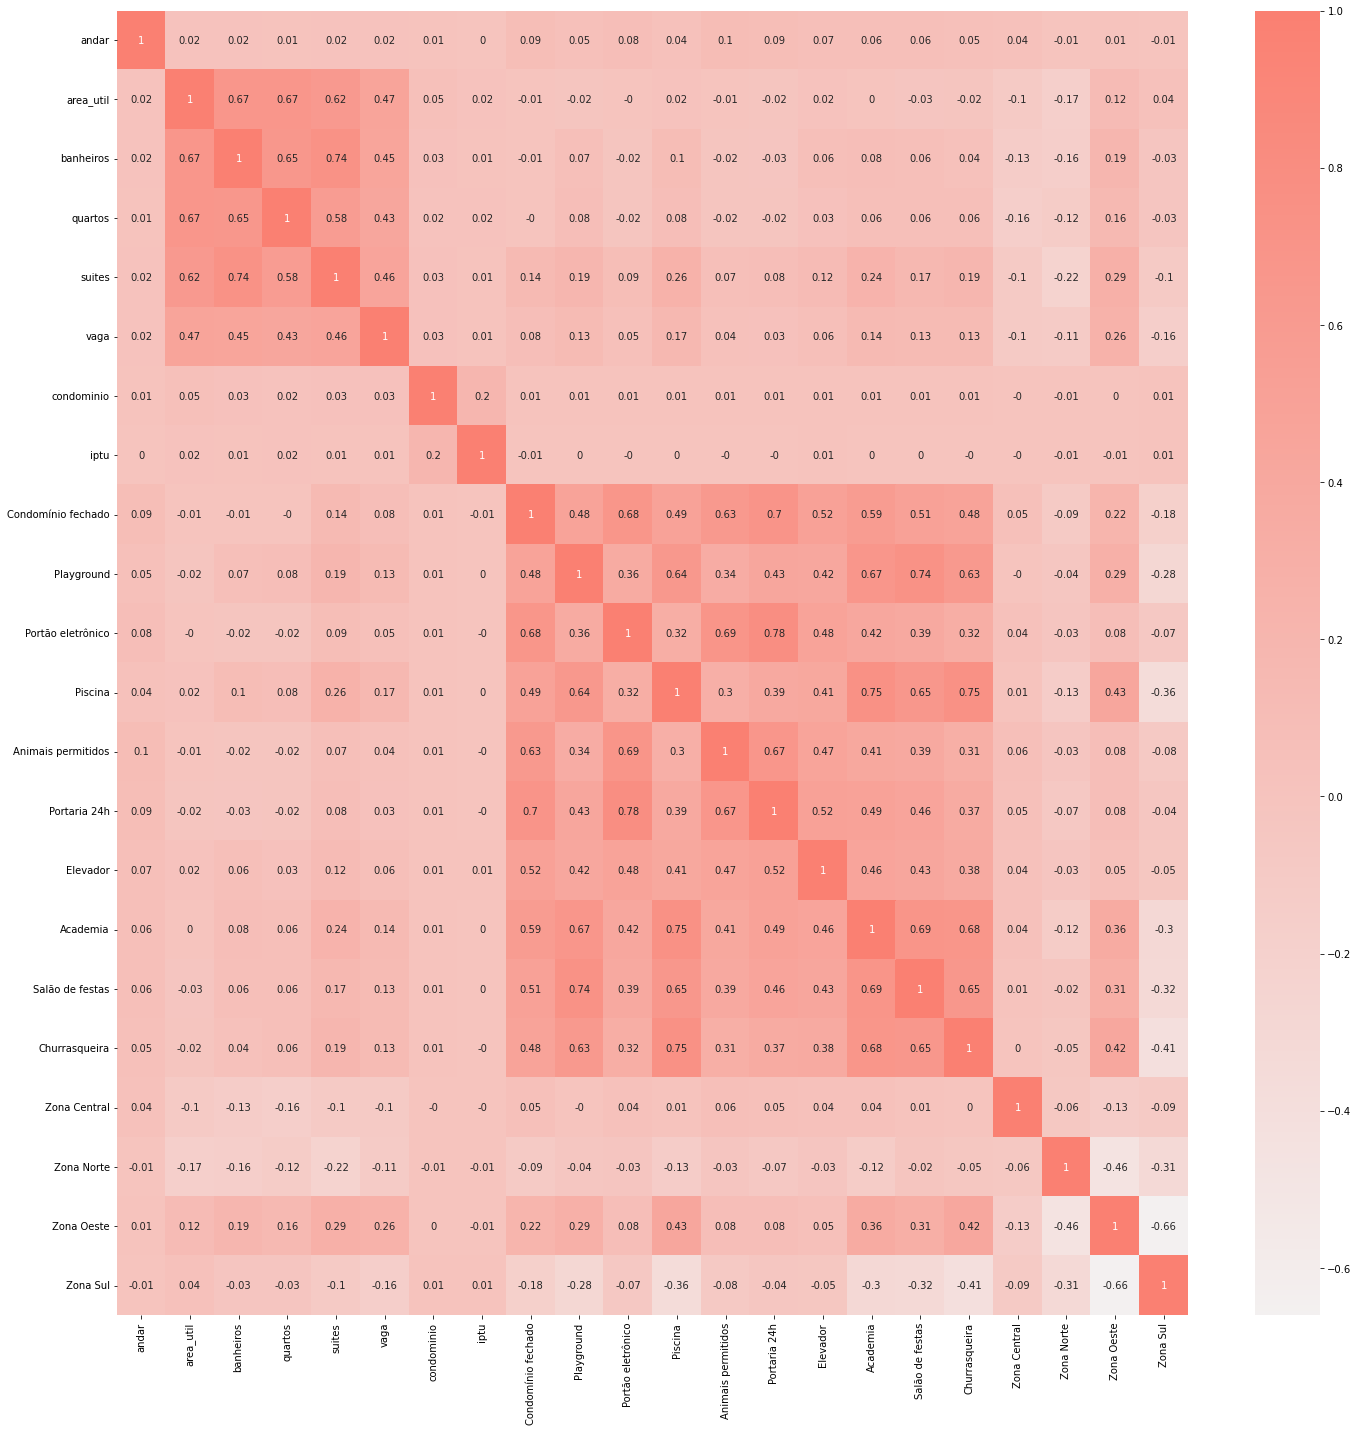

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24,24))
paleta = sns.color_palette('light:salmon', as_cmap=True)
sns.heatmap(dataframe_correlacao.round(2), annot=True, cmap=paleta)

É possível concluir do gráfico que não há variáveis que sejam tão correlacionadas a ponto que valha a pena remover uma delas. Assim, o dataset segue com as mesmas colunas

## 2.6 Salvando e carregando datasets em parquet

In [201]:
# Salvamento

# Dataset pronto para regressão
dataset_anuncio_regressao.write\
    .parquet(
             path='/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_anuncio_para_regressao'\
             ,mode='overwrite')

# Dataset limpo SEM dummies
dataset_limpo_sem_dummies.write\
    .parquet(
             path='/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_anuncio_sem_dummies'\
             ,mode='overwrite')
    
# Dataset COM dummies
dataset_limpo_com_dummies.write\
    .parquet(
             path='/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_anuncio_com_dummies'\
             ,mode='overwrite')


In [202]:
# Carregamento

# Dataset pronto para ser usado na regressão
dataset_anuncio_regressao = spark\
  .read\
  .parquet('/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_anuncio_para_regressao')

# Dataset limpo SEM dummies
dataset_limpo_sem_dummies = spark\
  .read\
  .parquet('/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_anuncio_sem_dummies')

# Dataset limpo COM dummies
dataset_limpo_com_dummies = spark\
  .read\
  .parquet('/content/drive/MyDrive/Alura/Challenge_DS_2ed/dataset_anuncio_com_dummies')

## 2.7 Criação dos modelos de regressão

### 2.7.1 Definições para modelos de regressão

In [203]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Semente de aleatoriedade
SEED = 123521

# Separando amostras de treino e teste
treino, teste = dataset_anuncio_regressao.randomSplit([0.7, 0.3], seed=SEED)

# Métrica de avaliação
evaluator = RegressionEvaluator()

### 2.7.2 Regressor linear

In [115]:
from pyspark.ml.regression import LinearRegression

# Modelo de regressão
lr = LinearRegression(maxIter=5)
modelo_rl = lr.fit(treino)

# Previsões do modelo
previsoes_rl_treino = modelo_rl.transform(treino)

# Validação cruzada
grid_lr = ParamGridBuilder()\
  .addGrid(lr.regParam, [0.01, 0.1])\
  .addGrid(lr.elasticNetParam, [0.0, 1.0])\
  .addGrid(lr.maxIter, [5, 10, 20])\
  .build()
lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=grid_lr,
                       evaluator=evaluator,
                       numFolds=3,
                       seed=SEED)

# Modelo com validação cruzada
modelo_lr_cv = lr_cv.fit(treino)

# Predições dos modelos
previsao_treino_lr = modelo_rl.summary
previsao_teste_lr = modelo_rl.evaluate(teste)
previsao_teste_cv_lr = modelo_lr_cv.transform(teste)

In [116]:
# Métricas de avaliação

print('='*40)
print('REGRESSÃO LINEAR\n')
print('='*40)
print('Dados de treino')
print('='*40)
print('R²: %f' % previsao_treino_lr.r2)
print('RMSE: %f' % previsao_treino_lr.rootMeanSquaredError)
print('='*40)
print('Dados de teste SEM validação cruzada')
print('='*40)
print('R²: %f' % previsao_teste_lr.r2)
print('RMSE: %f' % previsao_teste_lr.rootMeanSquaredError)
print('='*40)
print('Dados de teste COM validação cruzada')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsao_teste_cv_lr, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsao_teste_cv_lr, {evaluator.metricName: "rmse"}))

REGRESSÃO LINEAR

Dados de treino
R²: 0.666945
RMSE: 850475.482454
Dados de teste SEM validação cruzada
R²: 0.662558
RMSE: 852387.762609
Dados de teste COM validação cruzada
R²: 0.662574
RMSE: 852367.270293


### 2.7.3 Decision tree regressor

In [121]:
# Importando biblliotecas
from pyspark.ml.regression import DecisionTreeRegressor

# Modelo sem validação cruzada
dtr = DecisionTreeRegressor(seed=SEED, maxDepth=5)
modelo_dtr = dtr.fit(treino)

# Validação cruzada
grid_dtr = ParamGridBuilder()\
  .addGrid(dtr.maxDepth, [2, 5, 7, 10])\
  .addGrid(dtr.maxBins, [10, 12, 15, 18])\
  .build()
dtr_cv = CrossValidator(
    estimator=dtr,\
    estimatorParamMaps=grid_dtr,\
    evaluator=evaluator,\
    numFolds=3,\
    seed=SEED)

# Modelo com validação cruzada
modelo_dtr_cv = dtr_cv.fit(treino)

# Previsões
previsoes_dtr_treino = modelo_dtr.transform(treino)
previsoes_dtr_teste = modelo_dtr.transform(teste)
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

In [122]:
print('='*40)
print('DECISION TREE REGRESSOR\n')
print('='*40)
print('Dados de treino')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print('='*40)
print('Dados de teste SEM validação cruzada')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print('='*40)
print('Dados de teste COM validação cruzada')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

DECISION TREE REGRESSOR

Dados de treino
R²: 0.743965
RMSE: 745681.388475
Dados de teste SEM validação cruzada
R²: 0.739269
RMSE: 749263.071139
Dados de teste COM validação cruzada
R²: 0.765197
RMSE: 711032.695394


### 2.7.4 Random forest regressor

In [123]:
from pyspark.ml.regression import RandomForestRegressor

# Modelo
rfr = RandomForestRegressor(seed=SEED, maxDepth=7, numTrees=10)
modelo_rfr = rfr.fit(treino)

# Validação cruzada
grid_rfr = ParamGridBuilder()\
  .addGrid(rfr.numTrees, [20, 30, 40])\
  .addGrid(rfr.maxDepth, [5, 7, 10])\
  .addGrid(rfr.maxBins, [10, 32, 45])\
  .build()
rfr_cv = CrossValidator(
    estimator=rfr,\
    estimatorParamMaps=grid_rfr,\
    evaluator=evaluator,\
    numFolds=3,\
    seed=SEED)

# Modelo com validação cruzada
modelo_rfr_cv = rfr_cv.fit(treino)

# Previsões
previsoes_rfr_treino = modelo_rfr.transform(treino)
previsoes_rfr_teste = modelo_rfr.transform(teste)
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [124]:
print('='*40)
print('RANDOM FOREST REGRESSOR\n')
print('='*40)
print('Dados de treino')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print('='*40)
print('Dados de teste SEM validação cruzada')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print('='*40)
print('Dados de teste COM validação cruzada')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

RANDOM FOREST REGRESSOR

Dados de treino
R²: 0.812564
RMSE: 638015.081476
Dados de teste SEM validação cruzada
R²: 0.799513
RMSE: 657024.077868
Dados de teste COM validação cruzada
R²: 0.836276
RMSE: 593736.362737


### 2.7.5 Gradient-boosted tree regression

In [125]:
# Biblioteca
from pyspark.ml.regression import GBTRegressor

# Modelo sem validação cruzada
gbtr = GBTRegressor(seed=SEED, maxDepth=5)
modelo_gbtr = gbtr.fit(treino)

# Validação cruzada
grid_gbtr = ParamGridBuilder()\
  .addGrid(gbtr.maxDepth, [4, 6, 8])\
  .addGrid(gbtr.maxBins, [25, 45, 65])\
  .addGrid(gbtr.maxIter, [5, 15, 25])\
  .build()
gbtr_cv = CrossValidator(
    estimator=gbtr,\
    estimatorParamMaps=grid_gbtr,\
    evaluator=evaluator,\
    numFolds=3,\
    seed=SEED)

# Modelo com validação cruzada
modelo_gbtr_cv = gbtr_cv.fit(treino) 

# Previsões
previsoes_gbtr_treino = modelo_gbtr.transform(treino)
previsoes_gbtr_teste = modelo_gbtr.transform(teste)
previsoes_gbtr_cv_teste = modelo_gbtr_cv.transform(teste)

In [126]:
print('='*40)
print('GRADIENT-BOOSTED TREE REGRESSOR\n')
print('='*40)
print('Dados de treino')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_gbtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbtr_treino, {evaluator.metricName: "rmse"}))
print('='*40)
print('Dados de teste SEM validação cruzada')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_gbtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbtr_teste, {evaluator.metricName: "rmse"}))
print('='*40)
print('Dados de teste COM validação cruzada')
print('='*40)
print("R²: %f" % evaluator.evaluate(previsoes_gbtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbtr_cv_teste, {evaluator.metricName: "rmse"}))

GRADIENT-BOOSTED TREE REGRESSOR

Dados de treino
R²: 0.823154
RMSE: 619729.332817
Dados de teste SEM validação cruzada
R²: 0.798511
RMSE: 658662.742732
Dados de teste COM validação cruzada
R²: 0.827441
RMSE: 609546.453471


# 3.0 Ciência de Dados - Modelo de Clusterização

## 3.1 Vetorização e ajuste da escala

In [143]:
# Definição das colunas de entrada para o PCA
dataset_limpo_com_dummies.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'caracteristicas',
 'bairro',
 'zona',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Condomínio fechado',
 'Playground',
 'Portão eletrônico',
 'Piscina',
 'Animais permitidos',
 'Portaria 24h',
 'Elevador',
 'Academia',
 'Salão de festas',
 'Churrasqueira',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [145]:
X = dataset_limpo_com_dummies.drop('id', 'caracteristicas', 'zona', 'bairro').columns
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Condomínio fechado',
 'Playground',
 'Portão eletrônico',
 'Piscina',
 'Animais permitidos',
 'Portaria 24h',
 'Elevador',
 'Academia',
 'Salão de festas',
 'Churrasqueira',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [147]:
from pyspark.ml.feature import VectorAssembler

# Vetorização
assembler = VectorAssembler(inputCols=X, outputCol='features')
dataset_anuncio_clusterizacao = assembler.transform(dataset_limpo_com_dummies).select('features','valor')

# Ajuste de escala
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(dataset_anuncio_clusterizacao)
dataset_anuncio_clusterizacao = scaler_model.transform(dataset_anuncio_clusterizacao)

# Visualização
dataset_anuncio_clusterizacao.show(truncate=False)

+---------------------------------------------------------------------------------------------------------+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                 |valor  |scaled_features                                                                                                                                                                                                                                                                                                                                                       |
+-------------------------------------------------

## 3.2 Redução de dimencionalidade (PCA)

In [148]:
from pyspark.ml.feature import PCA

# Quantidade de clusters a ser gerada
k=len(X)

# PCA
pca = PCA(k=k, inputCol='scaled_features', outputCol='pca_features')

## 3.3 Criação do pipeline

In [149]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols=X, outputCol='features'),
                                StandardScaler(inputCol='features', outputCol='scaled_features'),
                                PCA(k=k, inputCol='scaled_features', outputCol='pca_features')])

modelo_pca_pipeline = pca_pipeline.fit(dataset_limpo_com_dummies) # Dados antes do PCA

## 3.4 Modelo de clusterização (KMeans) e plotagem

In [151]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import vector_to_array

# Projeção
projection = modelo_pca_pipeline.transform(dataset_limpo_com_dummies)
projection.select('pca_features').show(truncate=False, n=5)

# Clusterização
kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster_pca').setK(k).setSeed(SEED)
modelo_kmeans = kmeans.fit(projection)
projection_kmeans = modelo_kmeans.transform(projection)
projection_kmeans.select(['pca_features', 'cluster_pca']).show()

# Adicionando eixos cartesianos ao dataset clusterizado
projection_kmeans = projection_kmeans.withColumn('x', vector_to_array('pca_features')[0])\
                                     .withColumn('y', vector_to_array('pca_features')[1])
projection_kmeans.select(['x', 'y', 'cluster_pca']).show()

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
+-----------------------------------------------------------------------

In [153]:
import plotly.express as px
from pyspark.ml.functions import vector_to_array

# Tabela de posições cartesianas, cluster e preço
pca_features_x_y = projection_kmeans.withColumn('x', vector_to_array('pca_features')[0])\
                                     .withColumn('y', vector_to_array('pca_features')[1])\
                                     .select(['x', 'y', 'cluster_pca', 'valor'])
pca_features_x_y.show()

# Gráfico de posições cartesianas divididas por cluster
fig = px.scatter(pca_features_x_y.toPandas(), x='x', y='y', color='cluster_pca', hover_data=['x', 'y', 'cluster_pca'])
fig.show()

+-------------------+--------------------+-----------+-------+
|                  x|                   y|cluster_pca|  valor|
+-------------------+--------------------+-----------+-------+
| -5.513360711292172| -0.4357629296306317|          9|15000.0|
| -4.826681839058174| -0.5302087869175582|          9|15000.0|
|  -4.31651386475021| -0.7524756437334277|          9|20000.0|
| -5.390483680822174| -0.2722753544748516|          9|20000.0|
| -5.510432881561522| -0.4362132955823256|          9|15000.0|
| -5.390483680822174| -0.2722753544748516|          9|20000.0|
| -4.830279809712871| -0.5346357388843199|          9|15000.0|
| -4.261561006164607|  -0.774172522731418|         11|15000.0|
| -4.830279360101955| -0.5346345184153651|          9|15000.0|
| -4.833301175053828| -0.5349842254468399|          9|17999.0|
|-1.3541364356750833| -1.6577778866718034|          2|15000.0|
|-4.3178307353419125| -0.7621665479978106|          9|19999.0|
| -4.739210477132983| -0.3184948192969137|          9|1

É possível notar que a clusterização ficou confusa, não separando tão bem regões clusterizadas. Há muita sobreposição.

## 3.5 Otimização do número de clusters e remontagem do pipeline

In [155]:
# Cálculo do custo computacional para as diversas quantidades de clusters

import numpy as np

custo = np.zeros(len(X))

for k in range(2,len(X)):
    kmeans = KMeans().setK(k).setSeed(SEED).setFeaturesCol('features')
    modelo_teste = kmeans.fit(projection)
    custo[k] = modelo_teste.summary.trainingCost

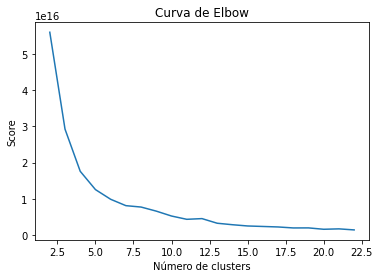

In [157]:
# Plotagem do custo por quantidade de clusters com pandas

import pandas as pd
import pylab as pl

df_custo = pd.DataFrame(custo[2:])
df_custo.columns = ['custo']
nova_coluna = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
df_custo.insert(0, 'cluster', nova_coluna)

pl.plot(df_custo.cluster, df_custo.custo)
pl.xlabel('Número de clusters')
pl.ylabel('Score')
pl.title('Curva de Elbow')
pl.show()

É possível de notar que o cotovelo da curva corresponde ao ponto de 7 clusters. 
Isso quer dizer que o número ideal de clústeres para o dataset é 7.

In [160]:
# Semente de aleatoriedade
SEED = 123521

# Clusterização
projection = modelo_pca_pipeline.transform(dataset_limpo_com_dummies)
kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster_pca').setK(7).setSeed(SEED)
modelo_kmeans = kmeans.fit(projection)
projection_kmeans = modelo_kmeans.transform(projection)
projection_kmeans.select(['pca_features', 'cluster_pca']).show()

# Remontagem do pipeline
pca_pipeline_otimizado = Pipeline(stages=[VectorAssembler(inputCols=X, outputCol='features'),
                                          StandardScaler(inputCol='features', outputCol='scaled_features'),
                                          PCA(k=2, inputCol='scaled_features', outputCol='pca_features'),
                                          KMeans(featuresCol='pca_features', predictionCol='cluster_pca').setK(7).setSeed(SEED)])

# Tabela de posições cartesianas, cluster e preço
pca_features_x_y = projection_kmeans.withColumn('x', vector_to_array('pca_features')[0])\
                                    .withColumn('y', vector_to_array('pca_features')[1])\
                                    .select(['x', 'y', 'cluster_pca', 'valor'])
pca_features_x_y.show()

# Gráfico de posições cartesianas divididas por cluster
fig = px.scatter(pca_features_x_y.toPandas(), x='x', y='y', color='cluster_pca', hover_data=['x', 'y', 'cluster_pca'])
fig.show()

+--------------------+-----------+
|        pca_features|cluster_pca|
+--------------------+-----------+
|[-5.5133607112921...|          1|
|[-4.8266818390581...|          1|
|[-4.3165138647502...|          1|
|[-5.3904836808221...|          1|
|[-5.5104328815615...|          1|
|[-5.3904836808221...|          1|
|[-4.8302798097128...|          1|
|[-4.2615610061646...|          6|
|[-4.8302793601019...|          1|
|[-4.8333011750538...|          1|
|[-1.3541364356750...|          0|
|[-4.3178307353419...|          1|
|[-4.7392104771329...|          1|
|[-6.2356807080737...|          1|
|[-4.1316166829595...|          5|
|[-6.8970351975465...|          1|
|[-3.8579865600065...|          6|
|[-3.5198243252433...|          5|
|[-4.8248361704855...|          1|
|[-6.2950553108160...|          1|
+--------------------+-----------+
only showing top 20 rows

+-------------------+--------------------+-----------+-------+
|                  x|                   y|cluster_pca|  valor|
+-------

É visível que a definição dos clusters melhorou significativamente de acordo com o gráfico de dispersão do modelo. O que contribui para o funcionamento do nosso sistema de agrupamento e recomendação.

### 3.6 Função de recomendação utilizando a distância euclidiana

In [161]:
# Simulação de um imóvel de interesse e que retorne recomendações
id_procurado = 'd2e3a3aa-09b5-45a0-9dcd-918847cd3ca3'

In [162]:
projection_kmeans.show()

+--------------------+-----+---------+---------+--------------------+--------------------+----------+-------+------+----+----------+----+-------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+------------+----------+----------+--------+--------------------+--------------------+--------------------+-----------+
|                  id|andar|area_util|banheiros|     caracteristicas|              bairro|      zona|quartos|suites|vaga|condominio|iptu|  valor|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|Elevador|Academia|Salão de festas|Churrasqueira|Zona Central|Zona Norte|Zona Oeste|Zona Sul|            features|     scaled_features|        pca_features|cluster_pca|
+--------------------+-----+---------+---------+--------------------+--------------------+----------+-------+------+----+----------+----+-------+------------------+----------+-----------------+-----

In [163]:
# Determinação do cluster o qual é classificado o imóvel
cluster = projection_kmeans.filter(projection_kmeans.id == id_procurado)\
                           .select('cluster_pca')\
                           .collect()[0][0]
cluster

1

In [164]:
# Agrupamento de todos os imóveis do mesmo cluster do de interesse
imoveis_recomendados = projection_kmeans.filter(projection_kmeans.cluster_pca == cluster)\
                                        .select('id', 'pca_features')
imoveis_recomendados.show()

+--------------------+--------------------+
|                  id|        pca_features|
+--------------------+--------------------+
|d2e3a3aa-09b5-45a...|[-5.5133607112921...|
|085bab2c-87ad-452...|[-4.8266818390581...|
|18d22cbe-1b86-476...|[-4.3165138647502...|
|bed8a354-9317-442...|[-5.3904836808221...|
|12a13315-d67f-48f...|[-5.5104328815615...|
|a2e6d7a5-0ff0-484...|[-5.3904836808221...|
|a6e3173b-c950-4db...|[-4.8302798097128...|
|99f8d0f9-95a4-461...|[-4.8302793601019...|
|b3f44c1a-2d50-4d5...|[-4.8333011750538...|
|aa3606d8-8bcd-45e...|[-4.3178307353419...|
|df80b0d5-677c-4be...|[-4.7392104771329...|
|3d6c0218-9b7d-474...|[-6.2356807080737...|
|111472a2-afa1-4a7...|[-6.8970351975465...|
|e0a3d370-66dd-4f5...|[-4.8248361704855...|
|09c8ba2d-dbf1-487...|[-6.2950553108160...|
|33da5489-72c9-4d1...|[-5.5061204065476...|
|08511604-dffe-40a...|[-4.8248960007564...|
|03a386b6-7ab8-4ef...|[-5.5048326976878...|
|f63ae653-c3ac-4d1...|[-5.5178317254702...|
|01de0250-50cc-4e7...|[-5.512039

In [165]:
# Valores de features do imóvel procurado
componenetes_imovel = imoveis_recomendados.filter(imoveis_recomendados.id == id_procurado)\
                                          .select('pca_features').collect()[0][0]
componenetes_imovel

DenseVector([-5.5134, -0.4358, -0.4778, 0.1134, -0.2039, -0.7517, 0.6509, 0.0777, -0.0706, 0.0291, 1.6446, 1.6177, -0.9993, -0.7531, 0.1028, 0.2421, -0.2792, 0.2376, -0.4579, 1.1912, -0.3068, 0.4449, 1.2629])

In [166]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

# Função para ver se o imóvel escolhido se encontra na base de dados
def encontra_imovel(id_procurado, projection_imovel):
  resultado = projection_imovel.filter(projection_imovel.id == id_procurado).collect()
  if len(resultado) == 0:
    return False
  return True

In [176]:
# Função recomendadora

def recomendador(id):
  cluster = projection_kmeans.filter(projection_kmeans.id == id_procurado).select('cluster_pca').collect()[0][0]
  imoveis_recomendados = projection_kmeans.filter(projection_kmeans.cluster_pca == cluster)\
                                          .select('id', 'pca_features')
  componentes_imovel = imoveis_recomendados.filter(imoveis_recomendados.id == id_procurado)\
                                            .select('pca_features').collect()[0][0]

  def calcula_distancia(value):
    return euclidean(componentes_imovel, value)

  udf_calcula_distancia = f.udf(calcula_distancia, FloatType())

  imoveis_recomendados_dist = imoveis_recomendados.withColumn('distancia', udf_calcula_distancia('pca_features'))

  recomendados = spark.createDataFrame(imoveis_recomendados_dist.sort('distancia').take(10))
  
  recomendados.join(dataset_limpo_sem_dummies,recomendados.id == dataset_limpo_sem_dummies.id,"inner")\
              .drop('pca_features')\
              .show(truncate=False)

In [177]:
encontra_imovel(id_procurado, projection_kmeans) # Verifica se o imóvel se encontra na base de dados

True

In [178]:
from pyspark.sql import functions as f # Importando funções sql

recomendador(id_procurado)

# A coluna de distância foi deixada apenas por demonstração de funcionamento da função de recomendação
# A primeira  linha, que possui distância zero, trata do próprio imóvel usado para fazer a recomendação

+------------------------------------+-------------------+-----+---------+---------+----------------------------------------------------------------------------------------------------------------------+------------+----------+------------------------------------+-------+------+----+----------+----+--------+
|id                                  |distancia          |andar|area_util|banheiros|caracteristicas                                                                                                       |bairro      |zona      |id                                  |quartos|suites|vaga|condominio|iptu|valor   |
+------------------------------------+-------------------+-----+---------+---------+----------------------------------------------------------------------------------------------------------------------+------------+----------+------------------------------------+-------+------+----+----------+----+--------+
|d2e3a3aa-09b5-45a0-9dcd-918847cd3ca3|0.0                |3    |43    